In [1]:
# ! pip install -r requirements.txt

In [2]:
%reload_ext autoreload
%autoreload 2
%aimport

import foolbox as fb
import matplotlib.pyplot as plt
import pandas as pd

from src.math.attack_and_stats import run_attack
from src.model import ResNet20
from src.utils import attack_and_collect_stats

Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
target_model = ResNet20()
test_loader = target_model.make_test_loader_subset(100)  # leave empty for debug on 5 pre-selected indices

Files already downloaded and verified


In [4]:
history_dfs = []
final_history_dfs = []
fw_accuracies = {}
fw_avg_times = {}

EPSILONS = [0.0, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
# EPSILONS = [0.0, 0.0005, 0.005, 0.05, 0.5]

epsilons = EPSILONS  # [0.005]
algs = ['fw', 'fw_momentum', "fw_momentum_blackbox"]

for alg in algs:
    acc, time, hist = run_attack(
        target_model,
        test_loader,
        epsilons, 
        iterations_number=20,
        alg=alg,
        norm_p='l_inf',
    )
    history_dfs.append(hist)
    final_history = hist.groupby('example_idx').tail(1)
    final_history_dfs.append(final_history)
    fw_accuracies[alg] = acc
    fw_avg_times[alg] = time

final_history_dfs[-1]

Attack Method: fw	Norm: l_inf


100%|██████████| 18/18 [03:01<00:00, 10.10s/it]


Attack Method: fw_momentum	Norm: l_inf


100%|██████████| 18/18 [02:53<00:00,  9.64s/it]


Attack Method: fw_momentum_blackbox	Norm: l_inf


100%|██████████| 18/18 [30:55<00:00, 103.09s/it]


,example_idx,iter,convergence,success,target,pred,iter_time,epsilon,l_inf,model_loss
13260,1,1,21570.673828,False,6,6,1.063722,1.0,1.0,6.684412
13261,2,2,293.484924,False,6,6,1.061659,1.0,1.0,8.209643
13262,3,3,1230.607544,False,6,6,1.032130,1.0,1.0,6.820710
13263,4,4,1402.955078,False,6,6,1.106335,1.0,1.0,5.406977
13264,5,5,2289.525391,False,6,6,0.977375,1.0,1.0,6.736533
...,...,...,...,...,...,...,...,...,...,...
14035,776,16,806.092773,True,0,6,1.224693,1.0,1.0,-3.232830
14036,777,17,1124.472412,True,0,6,1.129539,1.0,1.0,-3.278252
14037,778,18,1161.195068,True,0,6,1.091932,1.0,1.0,-3.563450
14038,779,19,654.163025,True,0,6,1.083779,1.0,1.0,-3.742951


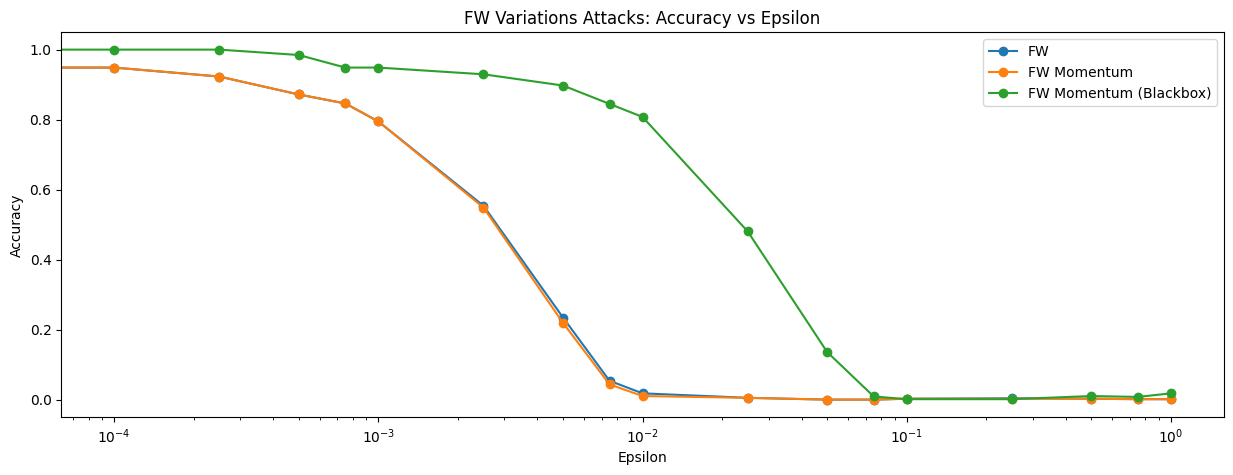

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(epsilons, fw_accuracies["fw"], "o-", label="FW")
plt.plot(epsilons, fw_accuracies["fw_momentum"], "o-", label="FW Momentum")
plt.plot(epsilons, fw_accuracies["fw_momentum_blackbox"], "o-", label="FW Momentum (Blackbox)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title(f"FW Variations Attacks: Accuracy vs Epsilon")
plt.xscale('log')
plt.legend()
plt.show()

In [6]:
def plot_convergence(history_dfs, algs, epsilon, y_axis = 'convergence'):
    final_history_dfs = [history.query(f"epsilon == {epsilon}").groupby('example_idx').tail(1) for history in history_dfs]
    plt.figure(figsize=(15, 5))
    for i, final_history in enumerate(final_history_dfs):
        alg = algs[i]
        print(alg)
        print(f"\tAttack success rate: {final_history['success'].mean()}")
        print(f"\tAverage iters: {final_history['iter'].mean()}")
        print(f"\tAverage time per epsilon: {fw_avg_times[alg]}")
        plt.plot(history_dfs[i].query(f"epsilon == {epsilon}").groupby('iter')[y_axis].mean(), label=algs[i])
    plt.xlabel("Iteration t")
    plt.ylabel("Convergence")
    plt.title(f"FW Algs Convergence for Epsilon = {epsilon}")
    plt.legend()
    plt.show()

fw
	Attack success rate: 0.7653846153846153
	Average iters: 10.5
	Average time per epsilon: 44.8559
fw_momentum
	Attack success rate: 0.7807692307692308
	Average iters: 10.5
	Average time per epsilon: 42.2846
fw_momentum_blackbox
	Attack success rate: 0.10256410256410256
	Average iters: 10.5
	Average time per epsilon: 443.6513


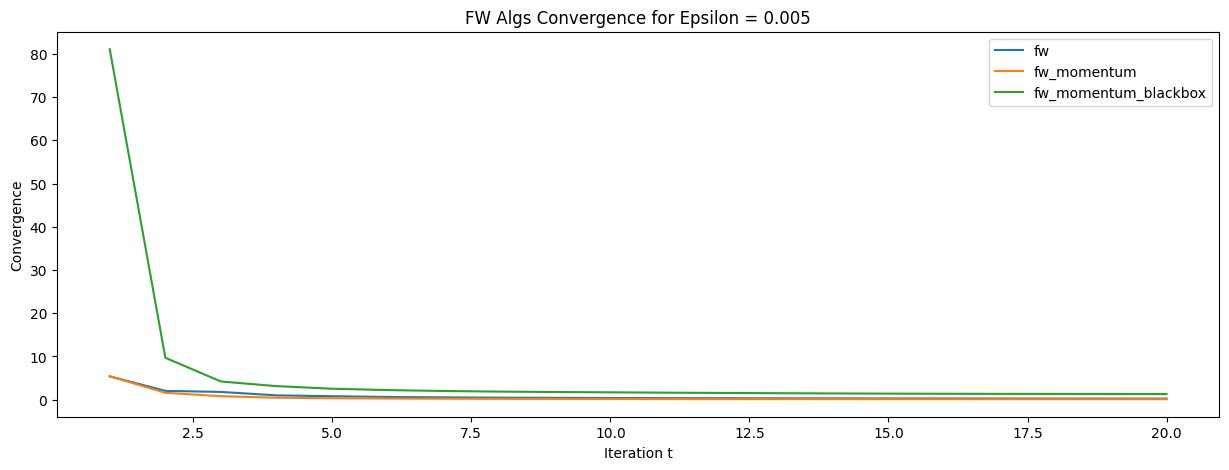

In [7]:
plot_convergence(history_dfs, algs, 0.005)

fw
	Attack success rate: 0.7653846153846153
	Average iters: 10.5
	Average time per epsilon: 44.8559
fw_momentum
	Attack success rate: 0.7807692307692308
	Average iters: 10.5
	Average time per epsilon: 42.2846


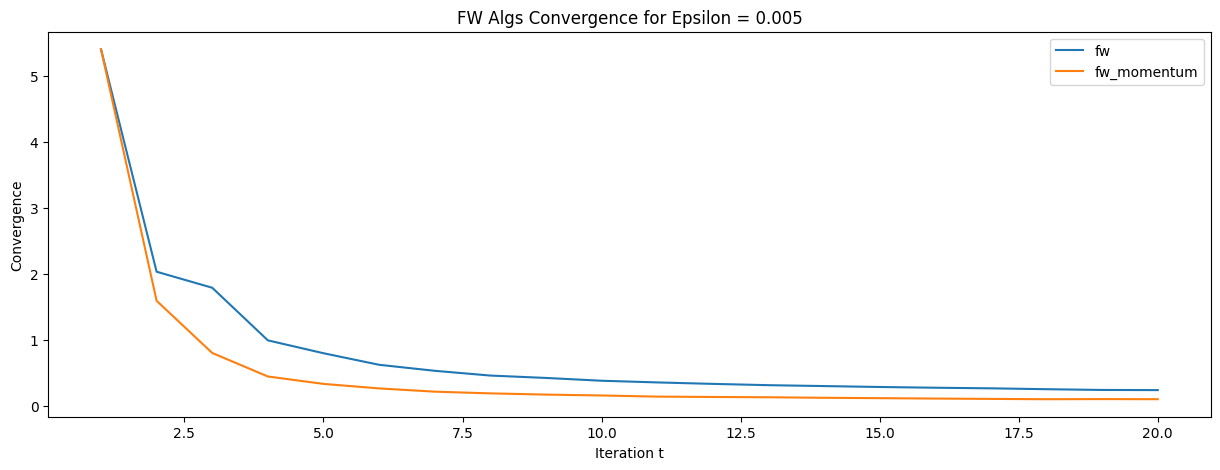

In [10]:
plot_convergence(history_dfs[:2], algs, 0.005)

### Compare with foolbox algs

In [8]:
fb_model = fb.PyTorchModel(target_model.get_model(), bounds=(0, 1))

pgd_attack = fb.attacks.LinfPGD()  # L_inf, for other norms use L2PGD or L1PGD
pgd_accuracies, pgd_avg_time = attack_and_collect_stats(EPSILONS, fb_model, pgd_attack, test_loader, "PGD", plot=False)

fgsm_attack = fb.attacks.LinfFastGradientAttack()  # L_inf, for other norms use L2FastGradientAttack or L1FastGradientAttack
fgsm_accuracies, fgsm_avg_time = attack_and_collect_stats(EPSILONS, fb_model, fgsm_attack, test_loader, "FGSM", plot=False)

100%|██████████| 18/18 [00:33<00:00,  1.85s/it]


OVERALL STATS
              Algorithm  Average time
0                    fw       44.8559
1           fw_momentum       42.2846
2  fw_momentum_blackbox      443.6513
3                   PGD       35.3766
4                  FGSM        1.8492


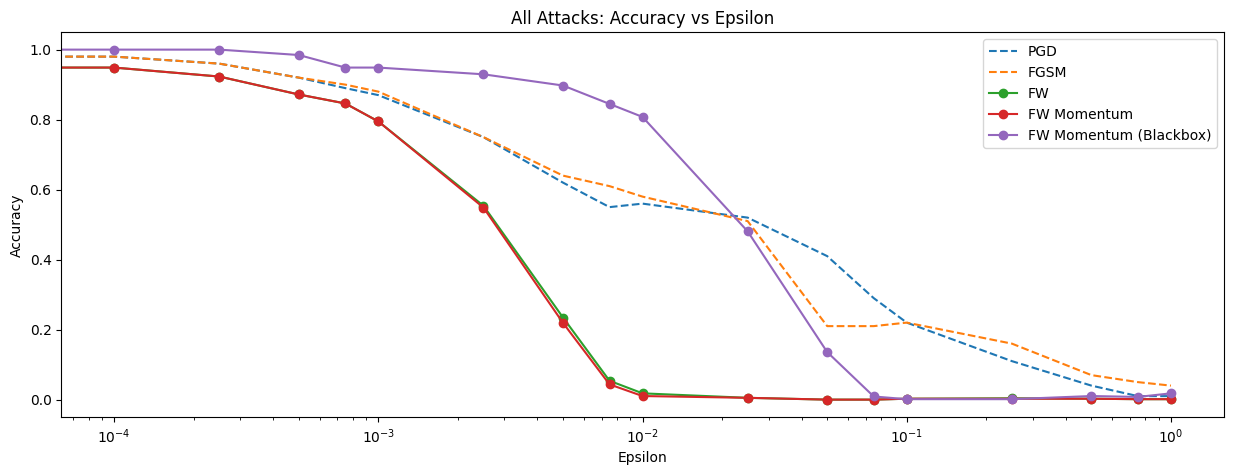

In [9]:
all_times = pd.DataFrame(
    list({**fw_avg_times, "PGD": pgd_avg_time, "FGSM": fgsm_avg_time}.items()),
    columns=["Algorithm", "Average time"]
)

print("OVERALL STATS")
print(all_times)

plt.figure(figsize=(15, 5))
plt.plot(epsilons, pgd_accuracies, "--", label="PGD")
plt.plot(epsilons, fgsm_accuracies, "--", label="FGSM")
plt.plot(epsilons, fw_accuracies["fw"], "o-", label="FW")
plt.plot(epsilons, fw_accuracies["fw_momentum"], "o-", label="FW Momentum")
plt.plot(epsilons, fw_accuracies["fw_momentum_blackbox"], "o-", label="FW Momentum (Blackbox)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title(f"All Attacks: Accuracy vs Epsilon")
plt.xscale('log')
plt.legend()
plt.show()